# Machine learning customer segmentation project
In this project, I will build a machine learning model for customer segmentation. It involves unsupervised learning, using an unlabeled training set for clustering. I intend to perform clustering to summarize customer segments of a retail store, identifying an ideal client group and building a loyalty program.

I will use the following pipeline, based on CRISP-DM framework:

1. Define the business problem.
2. Initial data understanding.
3. Exploratory data analysis and feature engineering.
4. Data cleaning and preprocessing.
5. Group customers into clusters, modelling.
6. Interpret the results, analysing the groups created (profiling). 
7. Provide marketing suggestions and the loyalty program.
8. Estimate financial results.

In this notebook, I will be covering steps 4 to 8 of the pipeline above. The main objective here is to segment our customers, studying the embedding space, applying techniques such as dimensionality reduction and comparing and evaluating different clustering algorithms in order to make the best segmentation. Moreover, profiles will be created and a loyalty program will be designed, such that concrete financial results will be calculated at the end.

### Importing the libraries

In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Modelling.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Utils.
from scripts.modelling_utils import *
from scripts.eda_utils import sns_plots
from scripts.artifacts_utils import save_object
import os

### Reading the data

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 2240 rows and 29 columns.


### Feature engineering
Obtaining the final dataset for clustering, applying all the feature engineering and data cleaning at once.

In [5]:
clustering_df, ids = feature_engineering(df)

In [6]:
clustering_df.columns

Index(['education', 'marital_status', 'income', 'recency', 'mntwines',
       'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'total_accepted_cmp', 'children', 'age', 'relationship_duration',
       'frequency', 'monetary', 'avg_purchase_value'],
      dtype='object')

In [7]:
print(f'The clustering dataset has {clustering_df.shape[0]} rows and {clustering_df.shape[1]} columns.')

The clustering dataset has 2228 rows and 22 columns.


# 4. Data cleaning and preprocessing
- In order to fit machine learning algorithms, there are some transformations we need to apply to the data
- Outliers: I have already treated the outliers, removing those representing inconsistent information.
- Missing values: I will replace the missing values in income column using KNNImputer, in order to avoid biased clustering results. It will take the mean income from the nearest n_neighbors for imputing.
- Numerical features: Some clustering algorithms are sensitive to feature scaling because they use distance calculations such as euclidean distance for training and predicting. Thus, I will apply StandardScaler to numeric attributes.
- Categorical features: I intend to apply OrdinalEncoder to the categorical features because education has an ordinal relationship and marital status has only two categories, which will be encoded as 0 and 1. Moreover, I will scale these features after encoding because some clustering algorithms are sensitive to it, due to distance calculations.

Checking missing values.

In [8]:
clustering_df.isna().sum()

education                 0
marital_status            0
income                   23
recency                   0
mntwines                  0
mntfruits                 0
mntmeatproducts           0
mntfishproducts           0
mntsweetproducts          0
mntgoldprods              0
numdealspurchases         0
numwebpurchases           0
numcatalogpurchases       0
numstorepurchases         0
numwebvisitsmonth         0
total_accepted_cmp        0
children                  0
age                       0
relationship_duration     0
frequency                 0
monetary                  0
avg_purchase_value        2
dtype: int64

I will build the preprocessor below, following the techniques mentioned above.

In [9]:
numerical_features = clustering_df.select_dtypes('number').columns.to_list()
categorical_features = clustering_df.select_dtypes('object').columns.to_list()

print(f'There are {len(numerical_features)} numerical features. They are: ')
print(numerical_features)
print(f'There are {len(categorical_features)} categorical features. They are: ')
print(categorical_features)

There are 20 numerical features. They are: 
['income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth', 'total_accepted_cmp', 'children', 'age', 'relationship_duration', 'frequency', 'monetary', 'avg_purchase_value']
There are 2 categorical features. They are: 
['education', 'marital_status']


In [10]:
num_pipeline = Pipeline(steps=[
    ('knn_imputer', KNNImputer()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder()),
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

Fitting the preprocessor and converting to DataFrame in order to perform embedding space study.

In [11]:
prepared_df = pd.DataFrame(preprocessor.fit_transform(clustering_df))

In [12]:
prepared_df.columns = clustering_df.columns

In [13]:
prepared_df.head()

,education,marital_status,income,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,total_accepted_cmp,children,age,relationship_duration,frequency,monetary,avg_purchase_value
0,0.317619,0.307307,0.979727,1.550286,1.755827,2.456149,1.471551,0.842345,0.358429,1.405182,2.633496,-0.559978,0.689529,-0.439298,-1.267017,1.015275,1.501310,1.039875,1.684878,1.129377,-0.892864,1.345208
1,-0.253280,-0.383626,-0.873488,-0.637803,-0.730377,-0.651835,-0.633150,-0.731880,-0.169383,-1.118159,-0.585846,-1.177160,-0.139543,-0.439298,1.393599,1.271558,-1.420017,-1.091331,-0.962467,-0.983387,-0.892864,1.345208
2,0.969888,-0.798186,0.359019,0.569418,-0.173283,1.340931,-0.149310,-0.040757,-0.697195,1.405182,-0.228141,1.291565,-0.554079,-0.439298,-1.267017,0.331856,0.040647,0.810670,0.284616,0.155932,-0.892864,-0.743380
3,-1.206779,-0.798186,-0.873488,-0.562352,-0.665920,-0.505577,-0.584766,-0.751077,-0.169383,-0.757682,-0.943550,-0.559978,0.274993,-0.439298,0.063291,-1.291266,-1.420017,-0.796447,-0.919177,-0.908784,-0.892864,-0.743380
4,0.325122,1.550987,-0.392365,0.418516,-0.214720,0.152585,-0.004159,-0.559099,1.414053,0.323750,0.129564,0.057203,-0.139543,-0.439298,0.063291,-1.034984,-1.420017,0.825414,-0.304793,-0.361616,0.572012,-0.743380


### Dimensionality reduction (PCA)
I will apply PCA, a dimensionality reduction technique, for some reasons:

-  PCA can remove noise and irrelevant information from the data, making it easier for clustering algorithms to identify meaningful patterns and clusters within the data.
- By capturing the most significant variations in the data, PCA can enhance the separation between clusters, leading to more accurate and interpretable clustering results.

Fitting PCA to the data.

In [14]:
pca = PCA()
pca.fit(prepared_df)

PCA()

Assessing each principal component's explained variance ratio.

In [15]:
pca.explained_variance_ratio_

array([3.99028866e-01, 9.56073177e-02, 5.75522669e-02, 5.38614381e-02,
       4.72305913e-02, 4.54197133e-02, 4.43978377e-02, 3.98015833e-02,
       3.17694535e-02, 3.08282040e-02, 2.64619373e-02, 2.21245493e-02,
       2.07573205e-02, 1.97431455e-02, 1.75507296e-02, 1.61132287e-02,
       1.25835658e-02, 1.07323851e-02, 6.42432297e-03, 1.89158031e-03,
       1.19963563e-04, 5.34925993e-33])

Obtaining a cumulative sum of the explained variance ratio.

In [16]:
cum_sum = [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]

Plotting the cumulative sum vs the number of components.

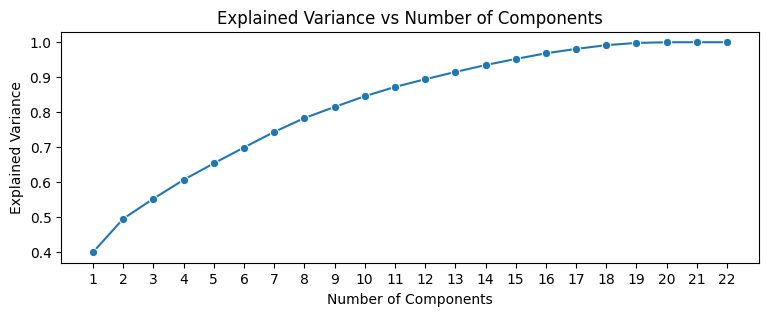

In [17]:
plt.figure(figsize = (9, 3))
sns.lineplot(x = range(1, 23), y = cum_sum, markers = True, marker = 'o')
plt.title('Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(1, 23, 1))
plt.show()

It is possible to observe that the data's variance is fairly well-preserved across the components. Anyway, I tested using different numbers of principal components and I will choose only three for the clustering task because it provided the best segmentation. This choice will lead to better clustering by reducing the impact of noise and dimensionality.

In [18]:
pca = PCA(n_components=3, random_state=42)
df_pca = pca.fit_transform(prepared_df)
print(f'The number of components is {pca.n_components_} and the explained variance ratio is {np.sum(pca.explained_variance_ratio_)}')

The number of components is 3 and the explained variance ratio is 0.5521873855257035


# 5. Clustering
I intend to compare different clustering algorithms, selecting one for customer segmentation. The algorithms I chose for comparison are K-Means, Hierarchical Clustering and Gaussian Mixtures Model. To evaluate each one of them and select an optimal k value, I will look at silhouette score.

The silhouette score is a metric used to evaluate the quality of clusters formed by a clustering algorithm. It measures how similar each data point in one cluster is to the other points within the same cluster (a) compared to the most similar neighboring cluster (b). The formula for the silhouette score is as follows:

Silhouette Score (s) = (b - a) / max(a, b)

Where:

'a' is the mean distance between a data point and all other data points in the same cluster.
'b' is the mean distance between a data point and all data points in the nearest cluster (i.e., the cluster that the data point is not a part of).
The silhouette score ranges from -1 to +1, with higher values indicating better-defined and well-separated clusters.

Silhouette scores for different numbers of K-Means clusters.

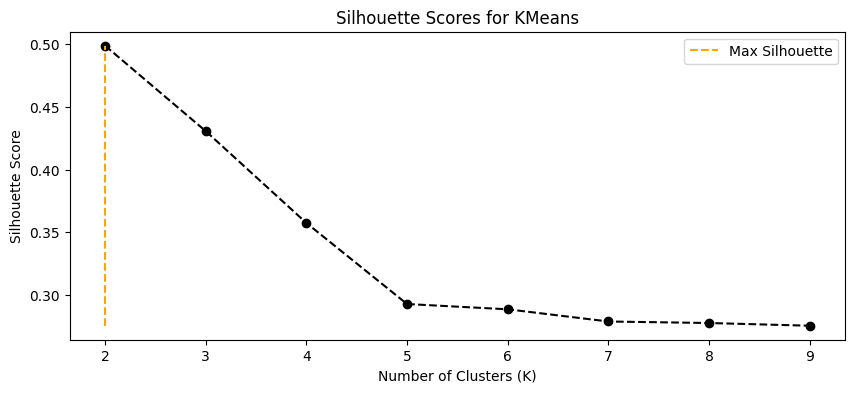

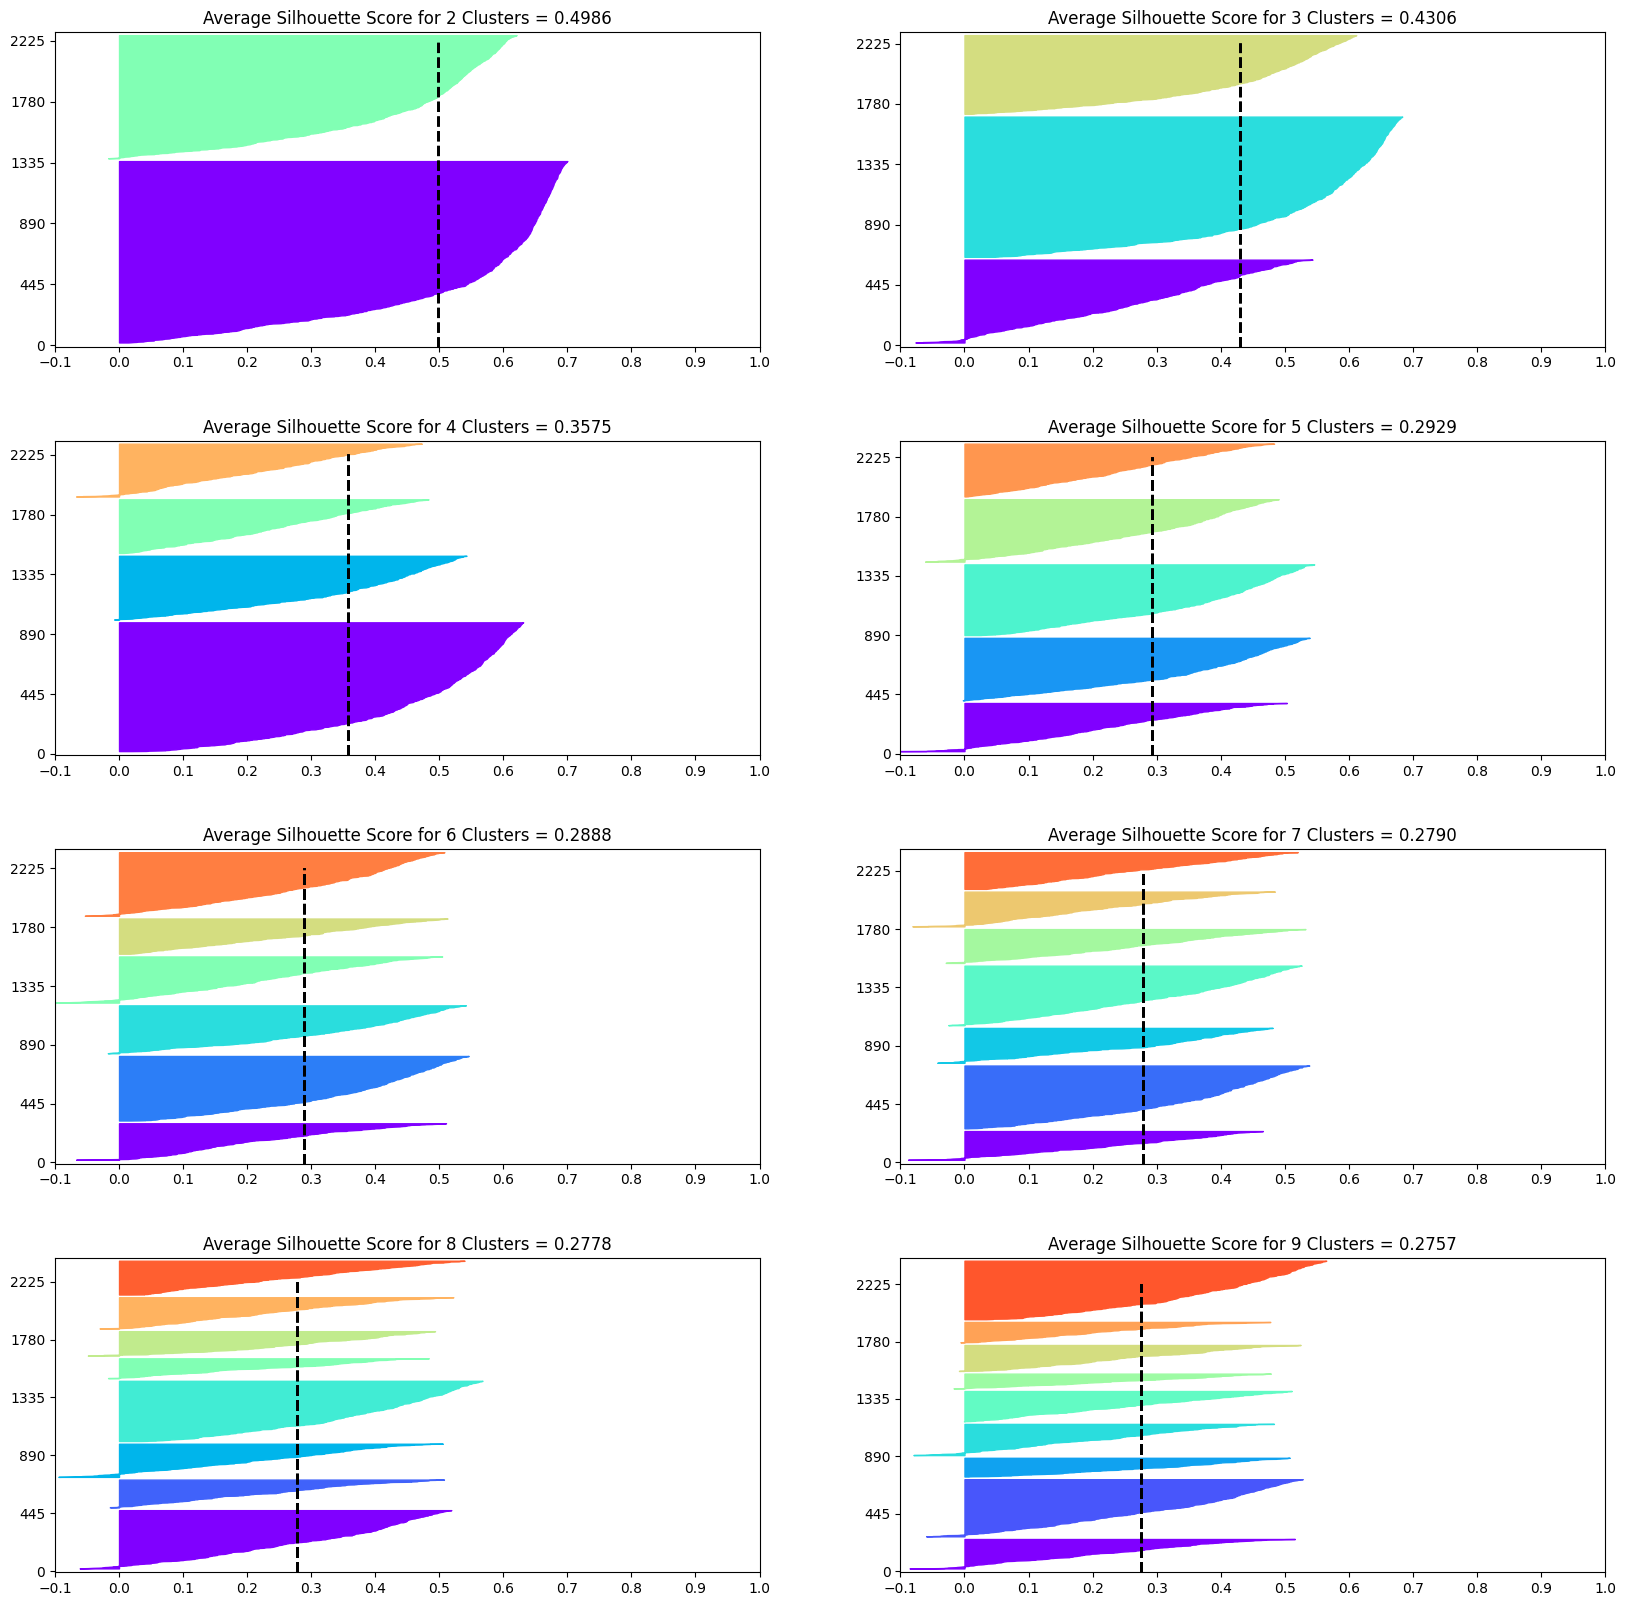

In [19]:
silhouette_analysis(data=df_pca, model=KMeans())

Silhouette scores for different numbers of GaussianMixture clusters.

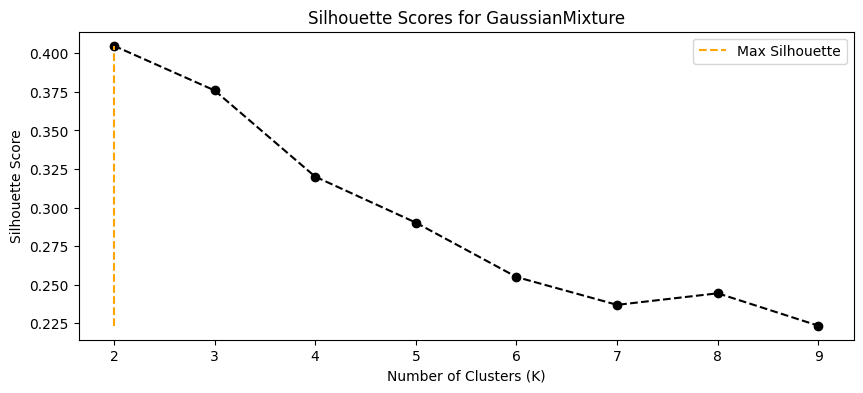

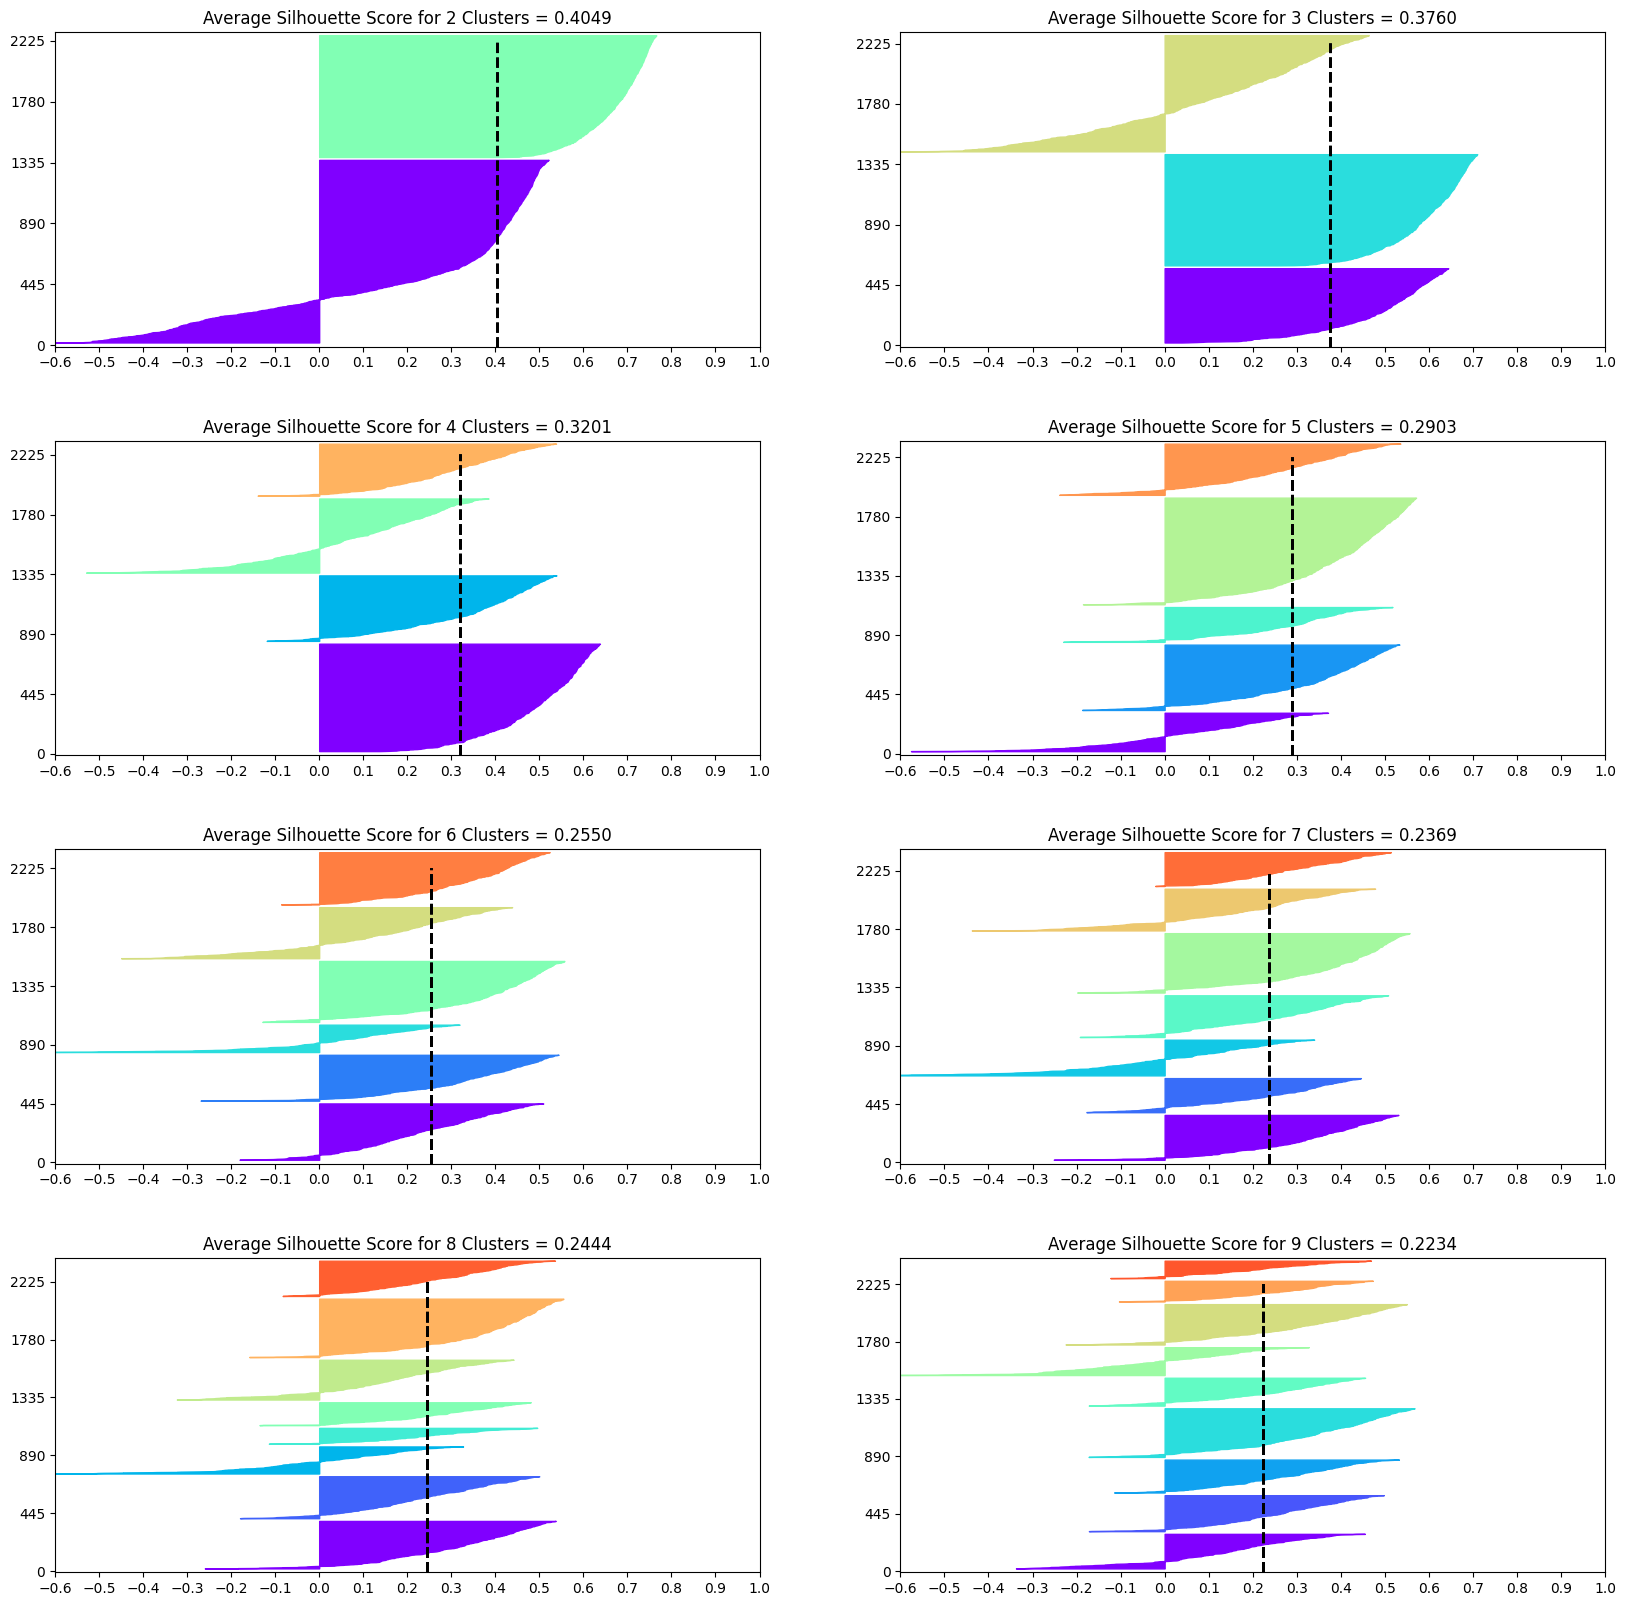

In [20]:
silhouette_analysis(data=df_pca, model=GaussianMixture())

Silhouette scores for different numbers of Hierarchical Clustering clusters.

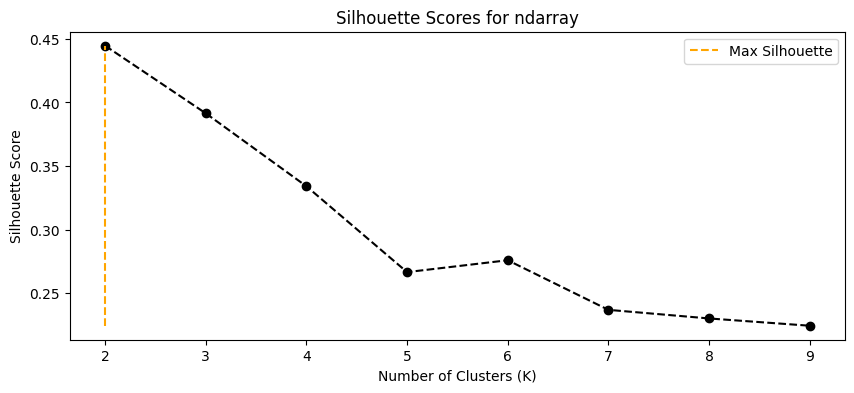

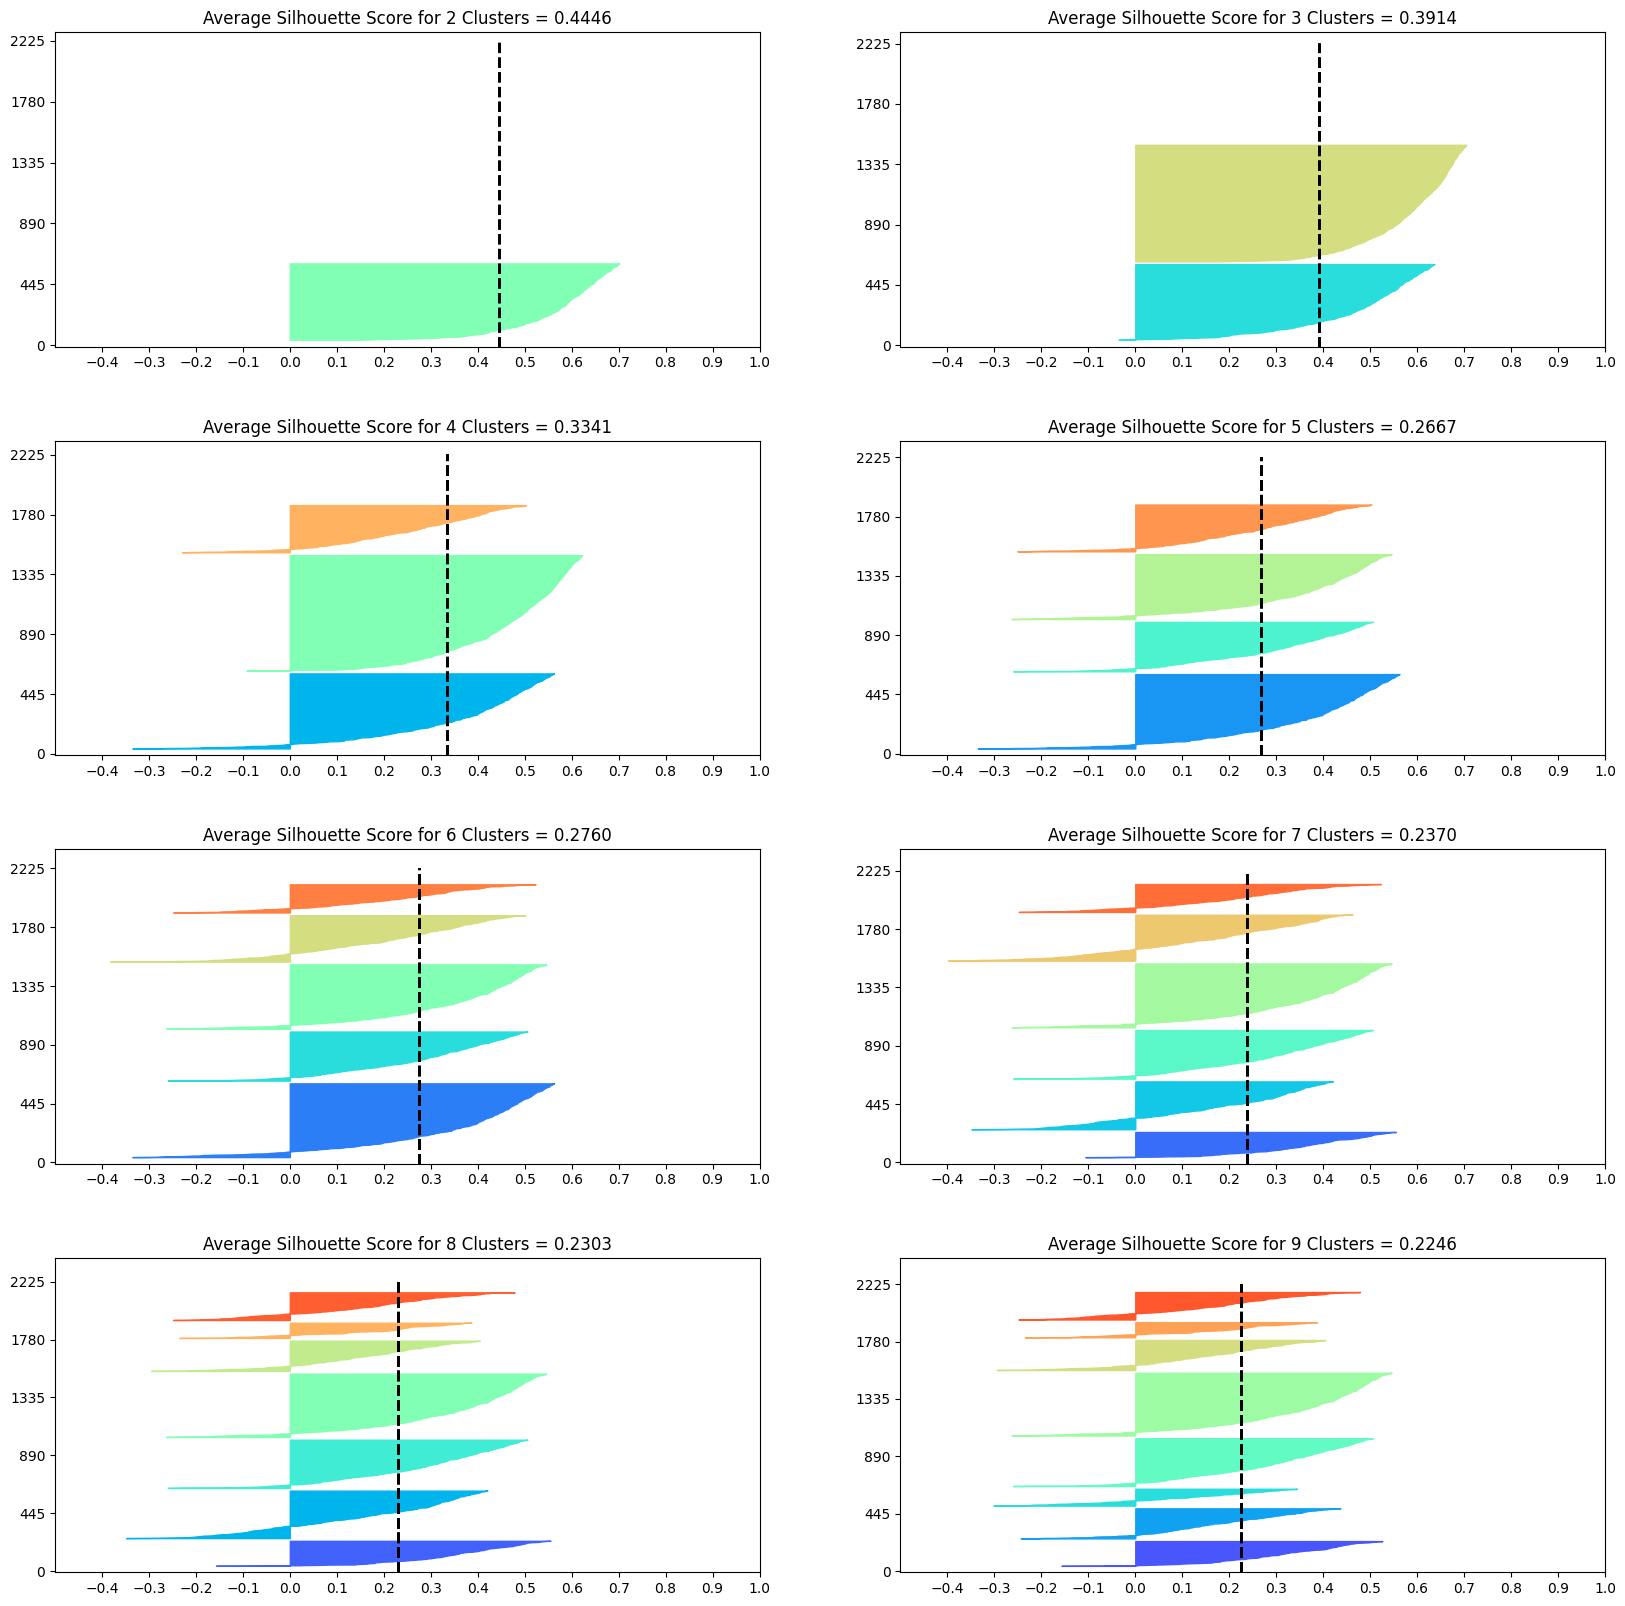

In [21]:
silhouette_analysis(data=df_pca, model=linkage(df_pca))

Clearly, K-Means was the best choice. Therefore, I will select it for the final model training and customer segmentation. Furthermore, the silhouette plot indicates that with k=5, most of the instances extend beyond the dashed line to the right, and the clusters have similar sizes. Thus, I will train K-Means with five clusters.

Training K-Means model with five clusters and obtaining the clusters' labels.

In [22]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=300, random_state=42)
kmeans.fit(df_pca)
labels = kmeans.labels_

Visualizing the clusters.

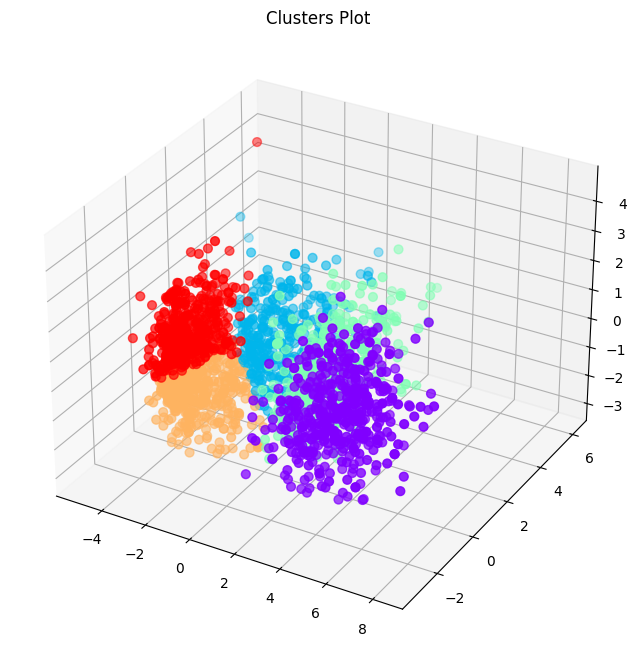

In [23]:
df_pca = pd.DataFrame(df_pca)

x, y, z = df_pca[0], df_pca[1], df_pca[2]

plt.figure(figsize=(10,8))

ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=labels, marker='o', cmap='rainbow')
ax.set_title('Clusters Plot')

plt.show()

It is possible to see that the clusters are well separated and KMeans did a good job in segmenting our customers.

# 6. Clusters analysis
I intend to visualize and summarize each cluster, in order to create personas, such that I can represent a cluster group by its characteristics. 

Creating a new dataframe with clusters' labels.

In [24]:
clusters_df = clustering_df.copy()
clusters_df['clusters'] = labels
clusters_df.head()

,education,marital_status,income,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,total_accepted_cmp,children,age,relationship_duration,frequency,monetary,avg_purchase_value,clusters
0,Graduate,Single,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,66,11,2.272727,1617,64.680000,0
1,Graduate,Single,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,2,69,9,0.666667,27,4.500000,3
2,Graduate,Partner,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,58,10,2.100000,776,36.952381,2
3,Graduate,Partner,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,1,39,9,0.888889,53,6.625000,3
4,Postgraduate,Partner,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,1,42,9,2.111111,422,22.210526,1


Clusters distribution.

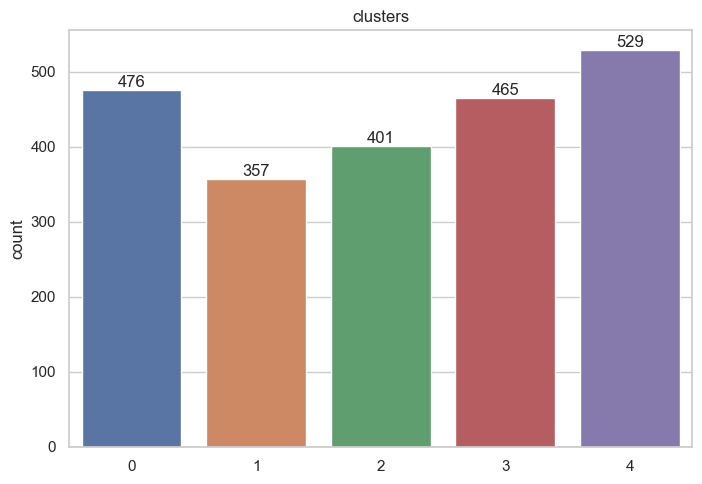

In [25]:
sns_plots(data=clusters_df, features=['clusters'], countplot=True)

The clusters have nearly the same size, with clusters 1 and 2 having slightly fewer observations.

Grouping the data by cluster, obtaining the average.

In [26]:
numerical_features = clusters_df.select_dtypes('number').columns.to_list()

grouped_clusters = clusters_df.groupby(['clusters'])[numerical_features].mean()
grouped_clusters.sort_values(['income', 'monetary', 'frequency'], ascending=False)

,income,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,total_accepted_cmp,children,age,relationship_duration,frequency,monetary,avg_purchase_value,clusters
clusters,,,,,,,,,,,,,,,,,,,,,
0,77641.276956,50.050420,644.962185,68.976891,488.817227,104.315126,72.649160,77.693277,1.058824,4.888655,6.071429,8.315126,2.569328,0.796218,0.117647,54.161765,9.951681,2.049444,1457.413866,74.015661,0.0
2,64396.085642,49.341646,582.054863,41.640898,206.655860,51.558603,40.952618,74.037406,3.017456,6.760599,4.399002,9.064838,5.032419,0.341646,0.937656,57.917706,10.129676,2.300081,996.900249,43.938573,2.0
1,49562.641243,48.053221,280.159664,11.753501,83.722689,18.862745,12.341737,47.969188,4.565826,5.946779,1.910364,6.008403,6.708683,0.201681,1.386555,56.784314,10.232493,1.808825,454.809524,24.413533,1.0
3,41588.222707,49.722581,56.440860,4.879570,23.920430,6.335484,5.092473,13.333333,1.812903,2.049462,0.690323,3.615054,5.215054,0.073118,1.406452,57.744086,9.380645,0.871459,110.002151,11.589841,3.0
4,28574.699809,48.240076,24.812854,5.166352,19.381853,7.342155,5.221172,15.708885,1.860113,1.937618,0.415879,2.903592,7.238185,0.081285,1.022684,46.200378,10.215501,0.697231,77.633270,10.373946,4.0


<b>Cluster 0:</b>
- Number of customers = 476
- Average income = $77,641.28
- Average frequency = 2.05
- Average monetary = $1,457.41
- Average purchase value = $74.01
- Prefer store and catalog purchases.
- Tend to make less web visits per month.
- Tend to accept more campaigns.
- Tend to have no children.

<b>Cluster 2:</b>
- Number of customers = 401
- Average income = $64,396
- Average frequency = 2.3
- Average monetary = $997.00
- Average purchase value = $44.00
- Prefer store and web purchases.
- Tend to make a considerable number of web visits per month.
- Some of them are prone to accept campaigns.
- Tend to have 1 child.

<b>Cluster 1:</b>
- Number of customers = 357
- Average income = $49,562.64
- Average frequency = 1.80	
- Average monetary = $454.81
- Average purchase value = $24.42
- Tend to make purchases with discount on the web, visiting the website a lot.
- Tend to have 1 child or more.
- Not prone to accept campaigns.

<b>Cluster 3:</b>
- Number of customers = 465
- Average income = $41,588.22
- Average frequency = 0.87	
- Average monetary = $110.00
- Average purchase value = $11.60
- Tend to visit the website a lot in a month, not purchasing too much.
- Tend to have 1 child or more.
- Not prone to accept campaigns.

<b>Cluster 4:</b>
- Number of customers = 529
- Average income = $28,574.70
- Average frequency = 0.70	
- Average monetary = $77.63
- Average purchase value = $10.38
- Tend to visit the website a lot in a month, not purchasing too much.
- Tend to have 1 child.
- Not prone to accept campaigns.
- Younger people with lower income.

<b>Considerations</b><br>
- Recency doesn't show any differentiation between the clusters. The same for amount spent on products types and relationship durations (all around 10 years). All the clusters spend more money on wine and meat products. 
- I will rename each cluster based on its characteristic in order to profile them.

<b>Customer profiling</b><br>

<b>Prosperous Shoppers (cluster 0):</b>
- This cluster comprises customers with a relatively high average income, moderate frequency, and substantial monetary spending.
- They prefer in-store and catalog purchases and tend to visit the web less frequently.
- They are open to accepting campaign offers and typically have no children.

<b>Web-Shrewd Shoppers (cluster 2):</b>
- Customers in this cluster have a decent income, a good frequency of purchases, but lower monetary spending.
- They prefer both store and web purchases, and they make a considerable number of web visits each month.
- Some are receptive to campaigns, and many have one child.

<b>Discount-Seeking Web Shoppers (cluster 1):</b>
- This cluster consists of customers with a lower income, lower frequency of purchases, and lower monetary spending.
- They prefer web purchases with discounts and frequently visit the website.
- Most have one or more children, and they are not very likely to accept campaigns.

<b>Web Enthusiasts with Frugal Habits (cluster 3):</b>
- Customers in this cluster have a relatively low income, low frequency, and modest monetary spending.
- They visit the website frequently but do not make many purchases.
- Many have one or more children, and they are not particularly inclined to accept campaigns.

<b>Young Budget Shoppers (cluster 4):</b>
- This cluster includes younger individuals with lower income, low frequency, and low monetary spending.
- They visit the website often but make relatively small purchases.
- Most have one child, and they are not receptive to campaigns.

Renaming the clusters in the dataframe for exploratory data analysis and better interpretation.

In [27]:
clusters_df['clusters'].replace({0: 'Prosperous', 1: 'Discount-Seeking', 
                                 2: 'Web-Shrewd', 3: 'Web Enthusiasts', 
                                 4: 'Young Budget'}, inplace=True)

### Exploratory data analysis
I will conduct some exploratory data analysis to create visualizations that make the clusters' behaviors clear and understandable.

Let's compare the averages of some features by cluster.

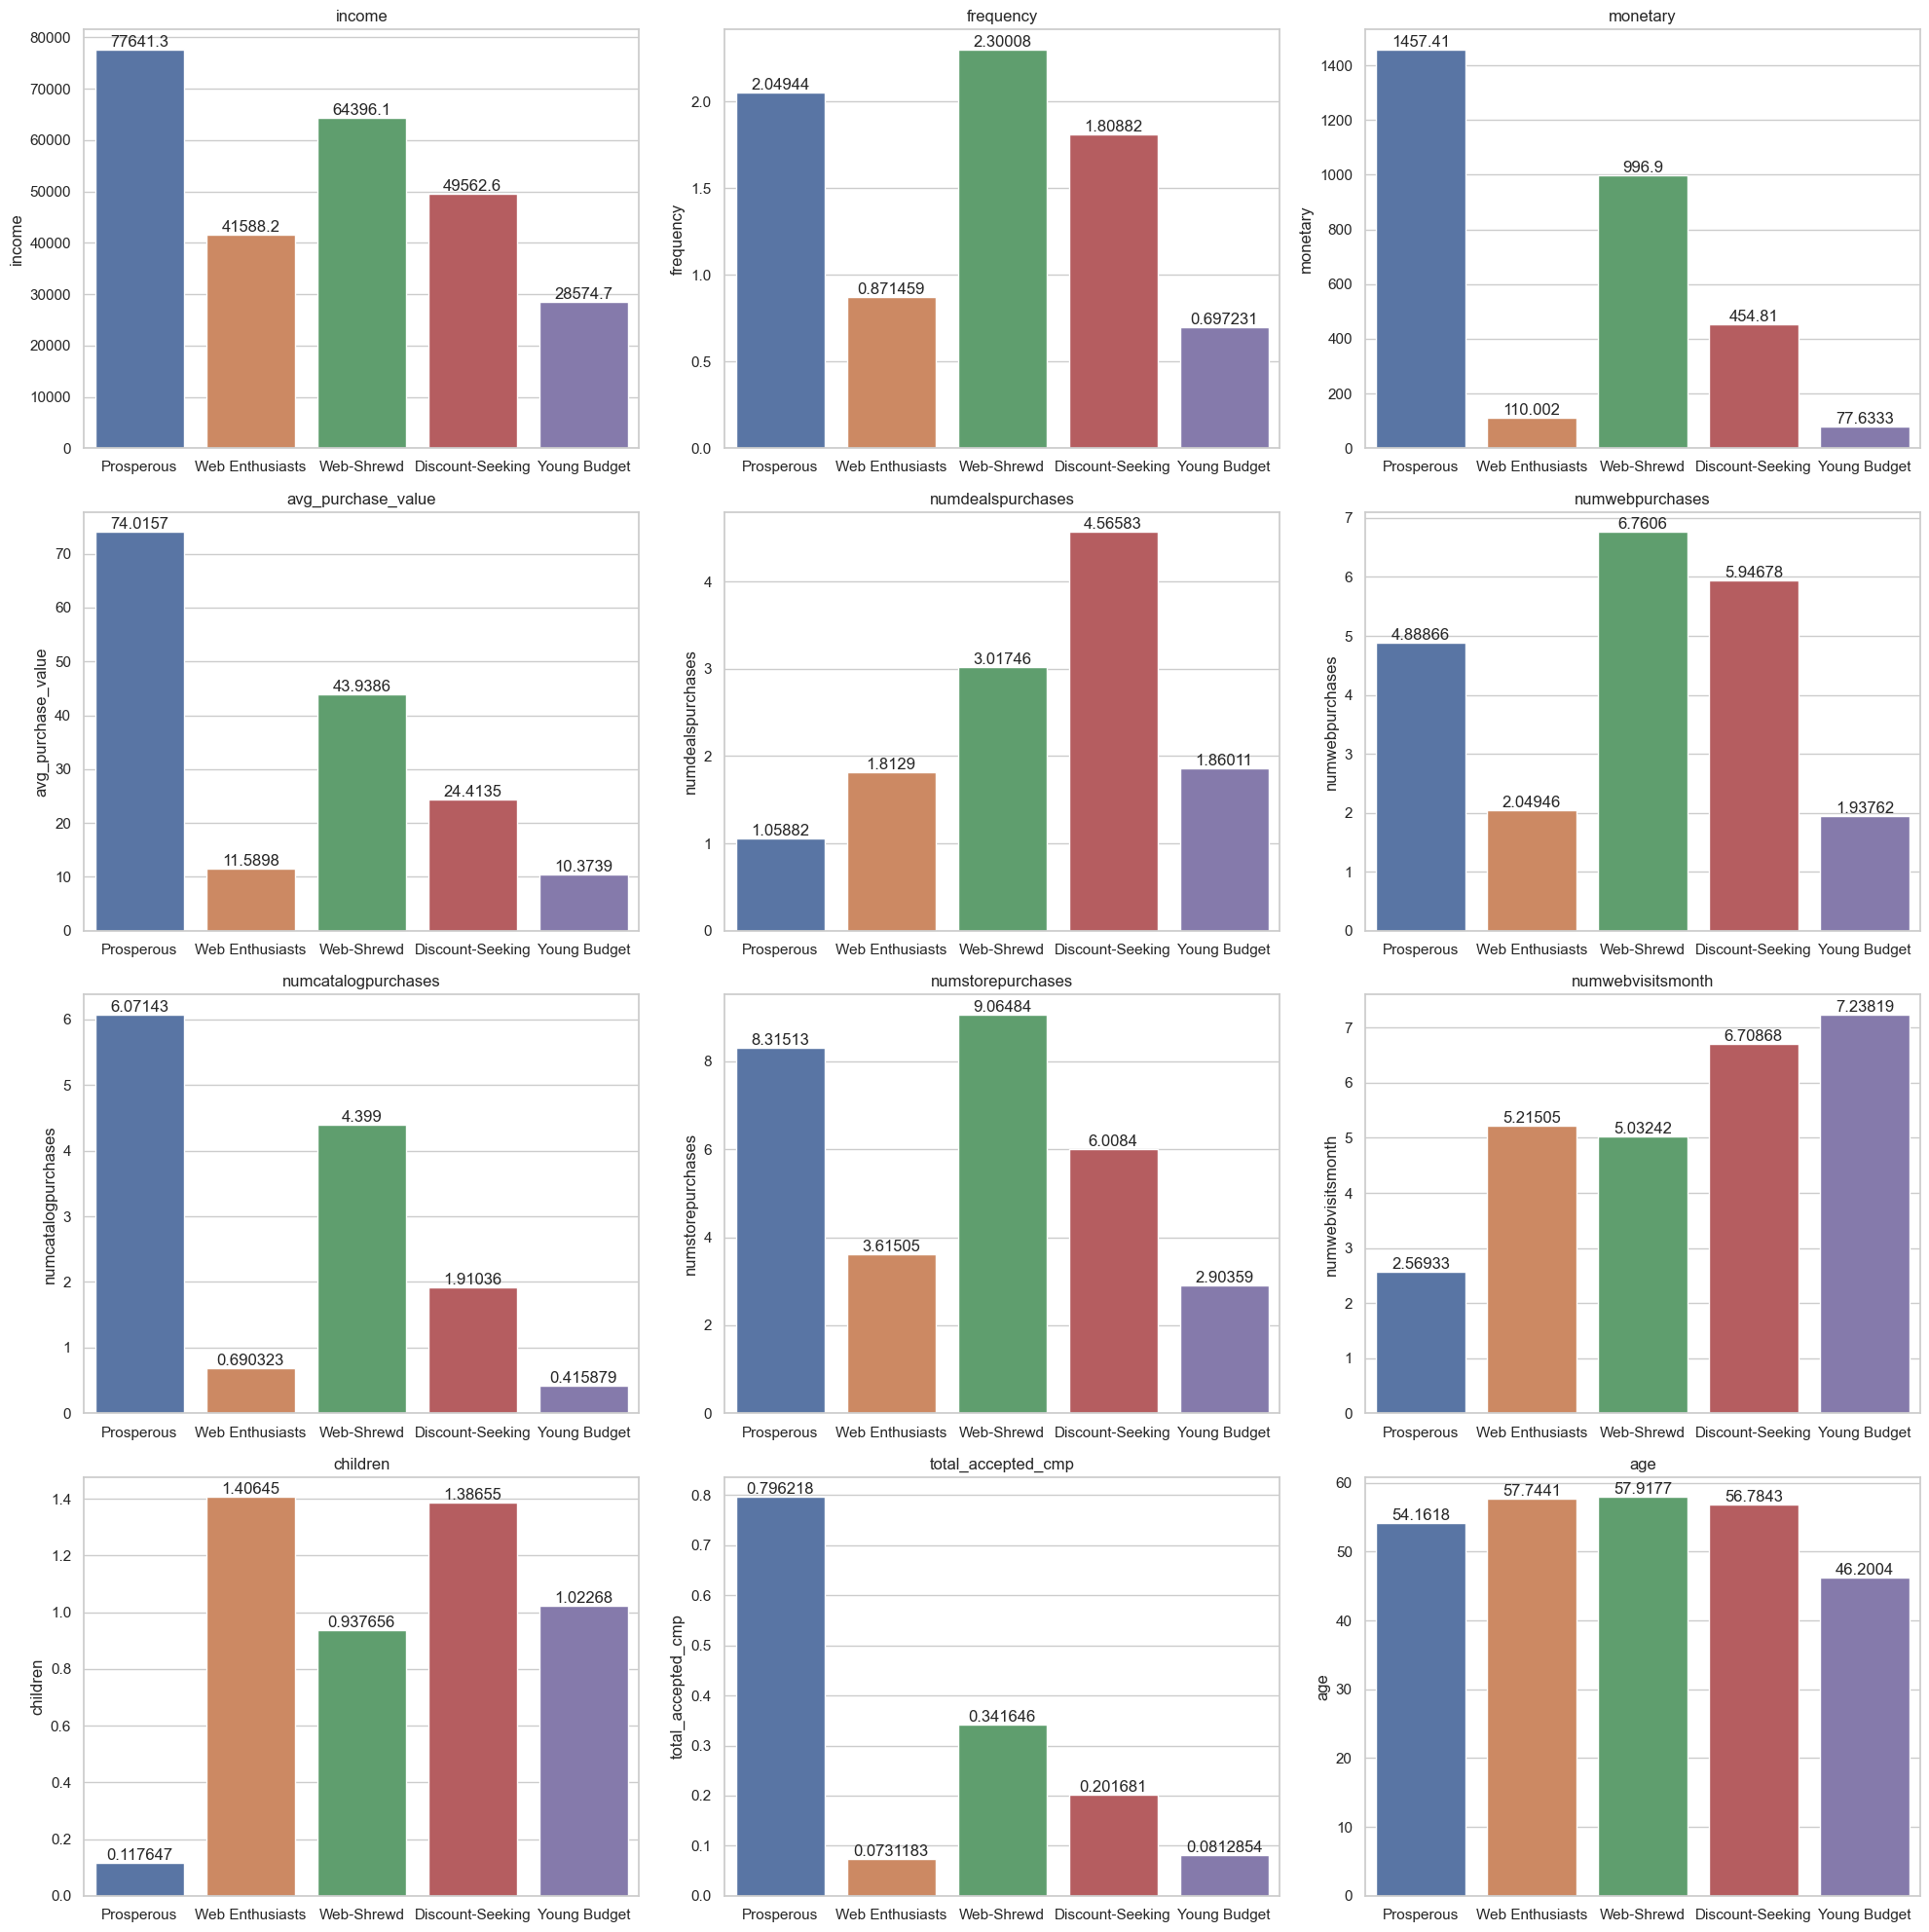

In [28]:
numplots_features = ['income', 'frequency', 'monetary', 'avg_purchase_value', 
                     'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 
                     'numwebvisitsmonth', 'children', 'total_accepted_cmp', 'age']

sns_plots(data=clusters_df, features=numplots_features, various_barplots=True, barplot_x='clusters')

Let's compare the distributions by cluster to reinforce what we saw at the barplots above.

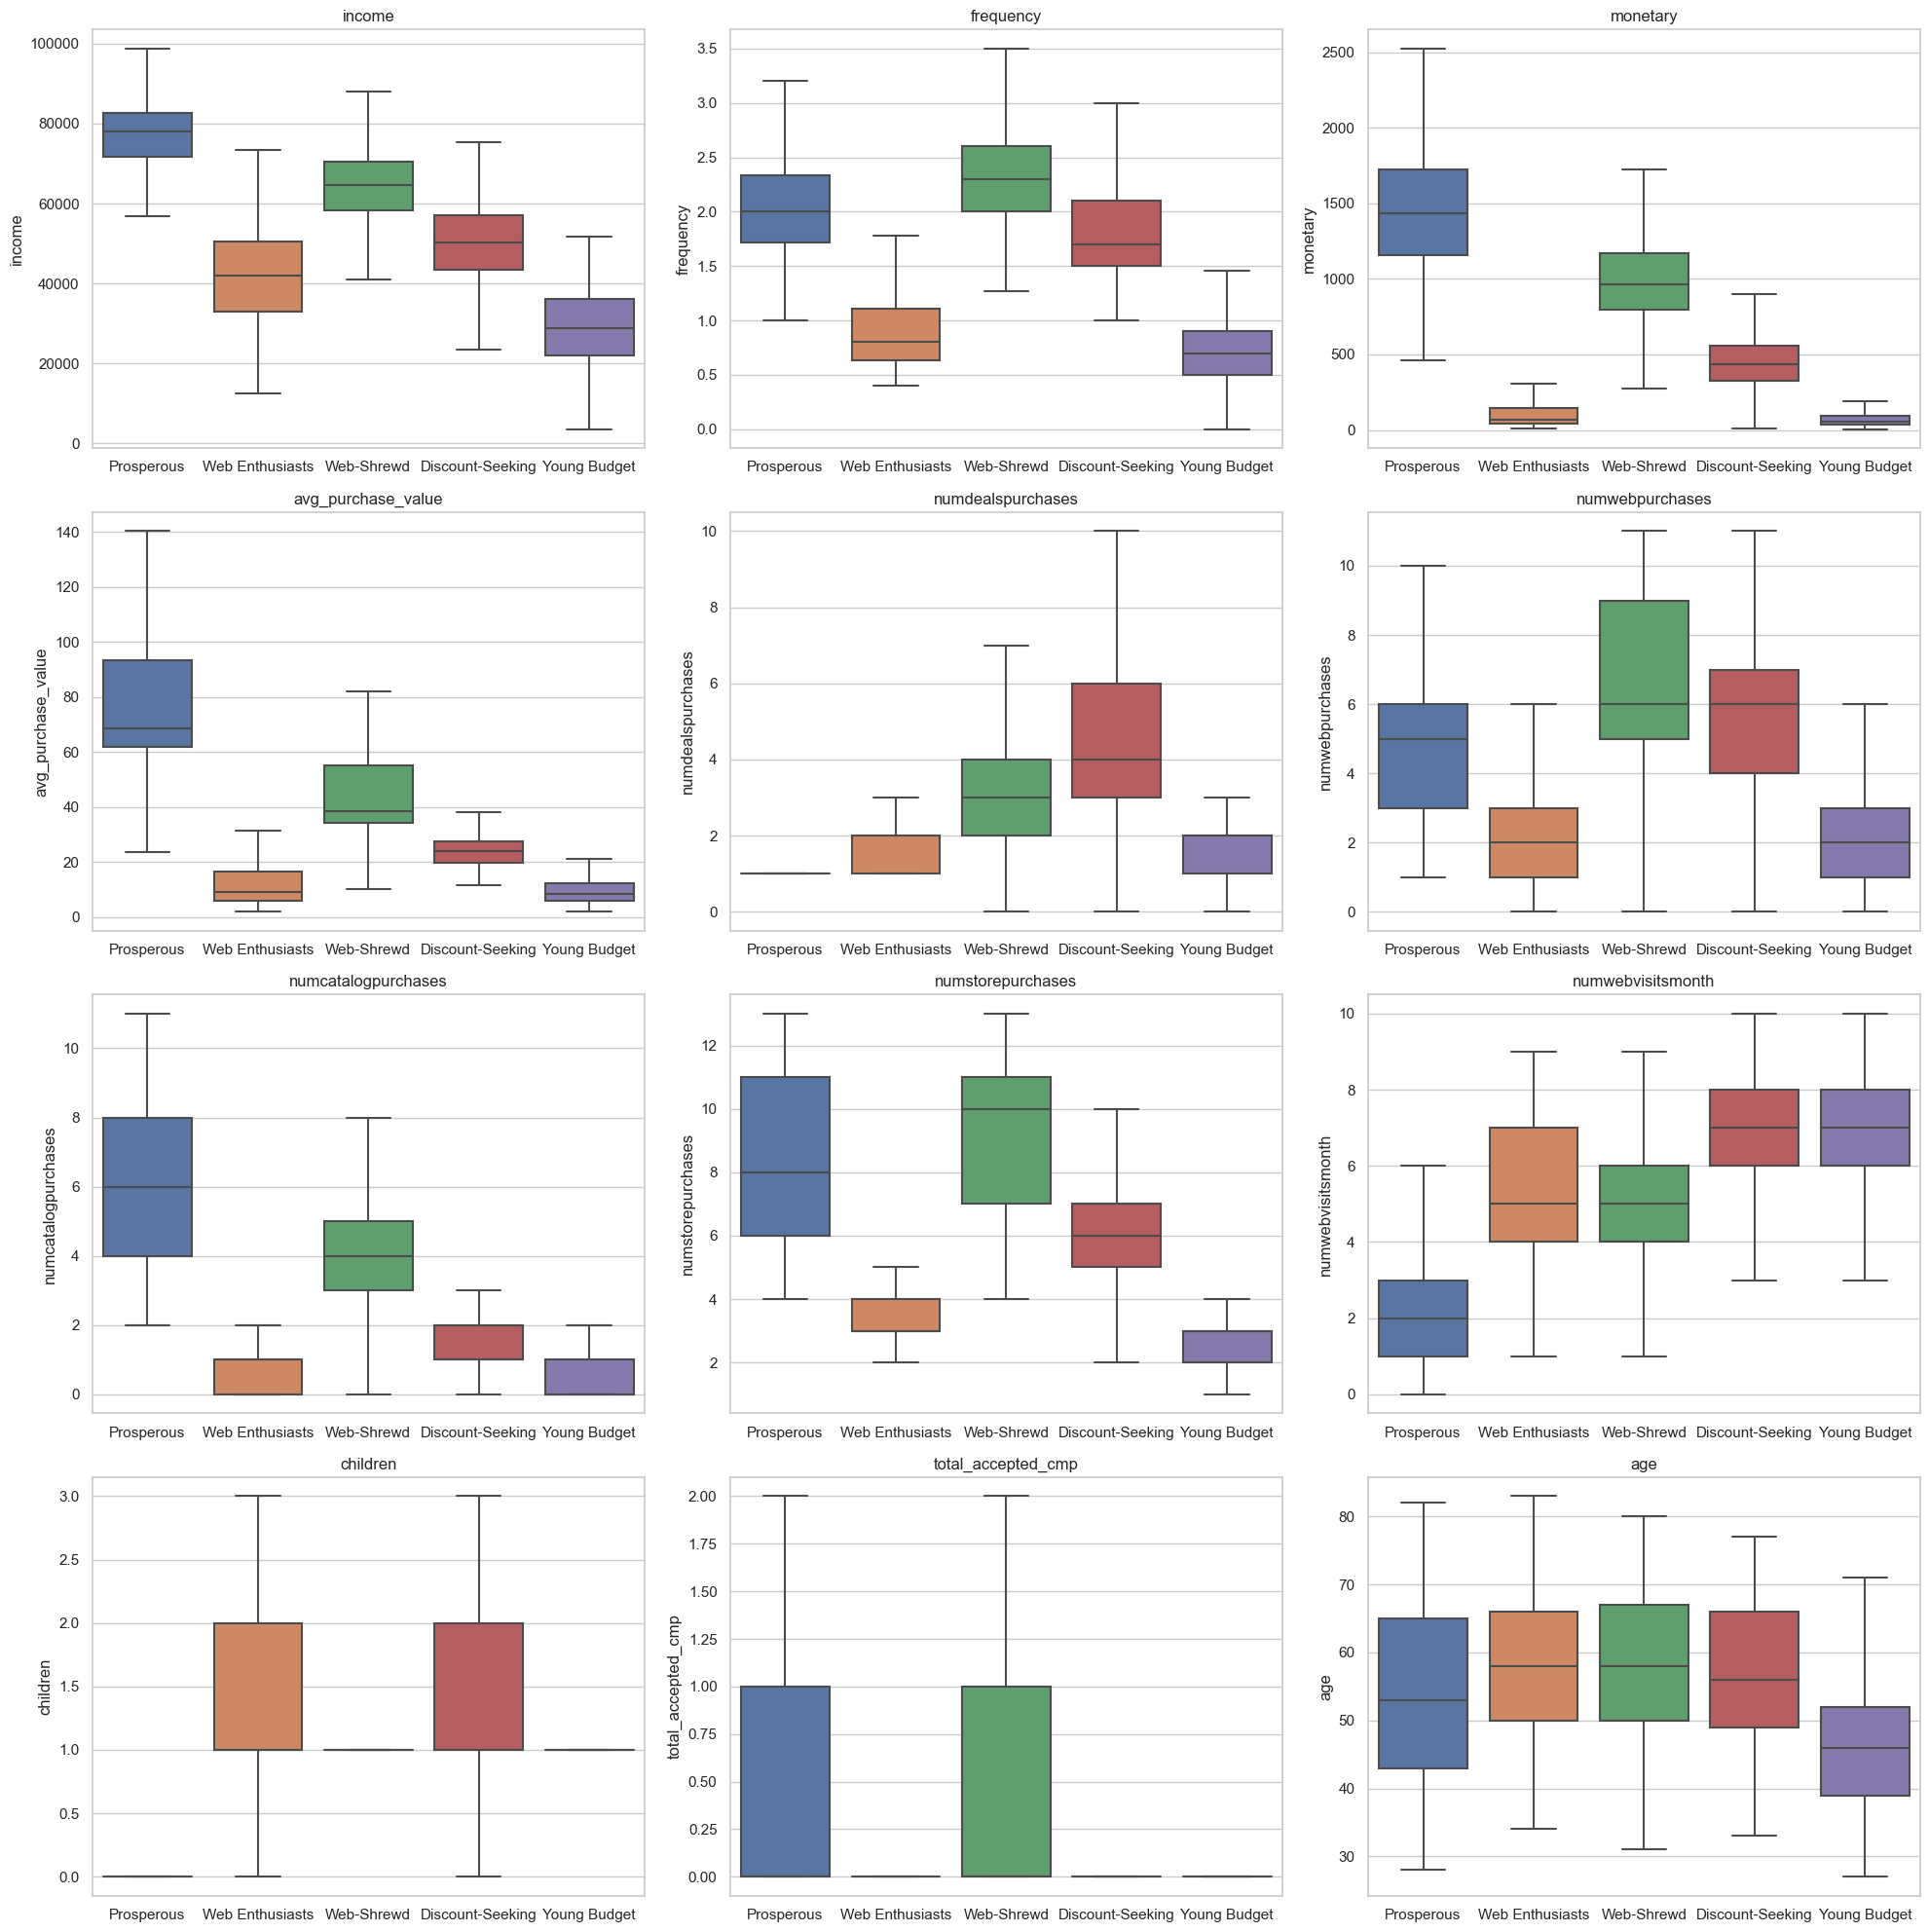

In [29]:
sns_plots(data=clusters_df, features=numplots_features, boxplot=True, boxplot_x='clusters')

Let's look at some scatterplots to assess the clusters separation in different values of numerical features.

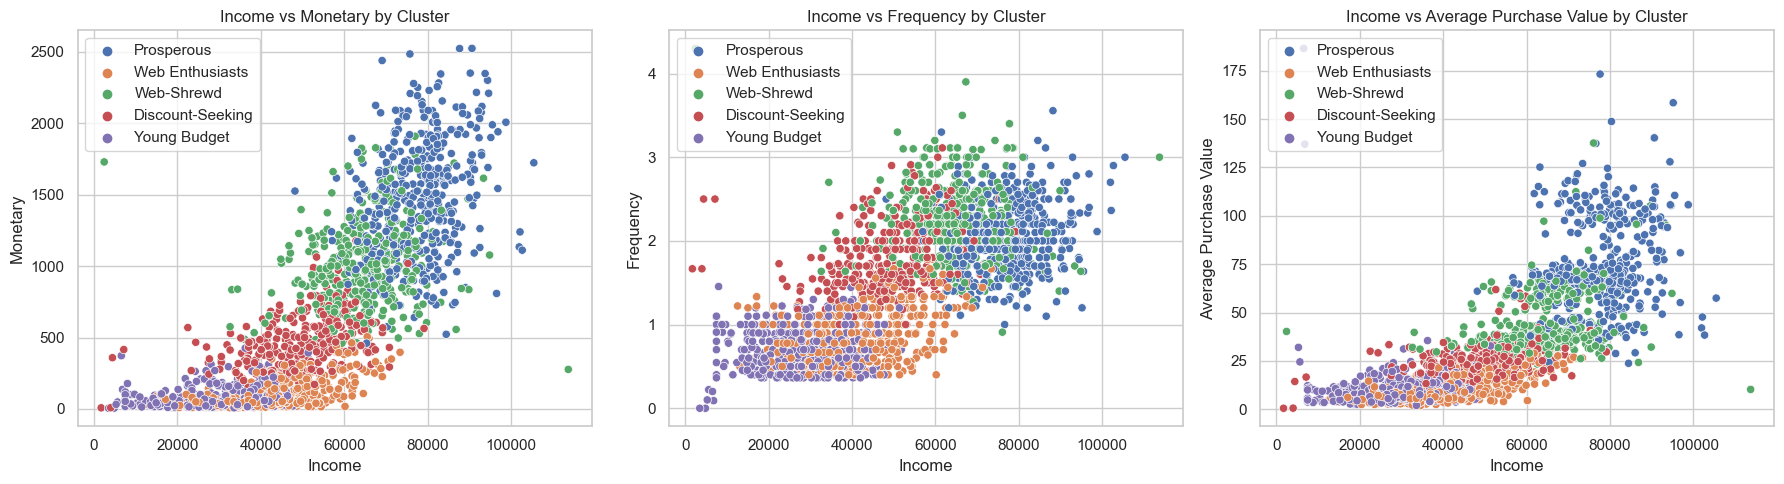

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax0 = sns.scatterplot(data=clusters_df, x='income', y='monetary', hue='clusters', ax=axes[0])
ax0.set_title('Income vs Monetary by Cluster')
ax0.set_xlabel('Income')
ax0.set_ylabel('Monetary')
ax0.legend(loc='upper left')

ax1 = sns.scatterplot(data=clusters_df, x='income', y='frequency', hue='clusters', ax=axes[1])
ax1.set_title('Income vs Frequency by Cluster')
ax1.set_xlabel('Income')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper left')

ax2 = sns.scatterplot(data=clusters_df, x='income', y='avg_purchase_value', hue='clusters', ax=axes[2])
ax2.set_title('Income vs Average Purchase Value by Cluster')
ax2.set_xlabel('Income')
ax2.set_ylabel('Average Purchase Value')
ax2.legend(loc='upper left')


plt.tight_layout()
plt.show()

Insights:
1. Both the barplots and boxplots confirm what we saw in the grouped data by cluster. The same for the scatterplots, there is indeed a separation between clusters in income, monetary, frequency and average purchase values.

Let's compare the counts of categorical features by cluster.

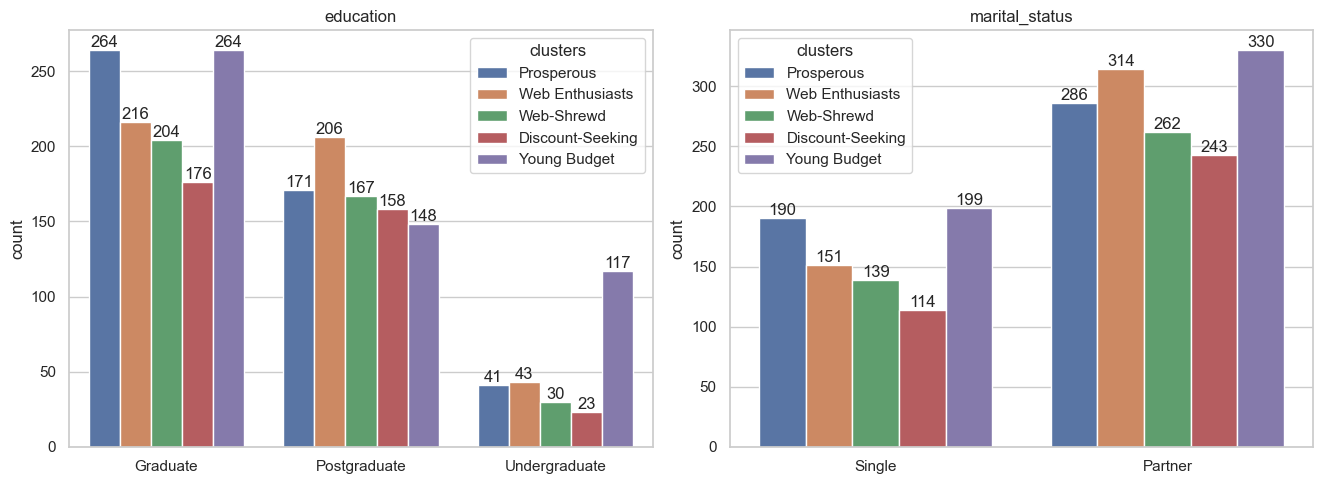

In [30]:
sns_plots(data=clusters_df, features=categorical_features, countplot=True, hue='clusters')

Insights:
1. Most of the undergraduate customers are at young budget cluster. This was expected, since they represent young people, with lower incomes, still studying and striving to build their lives.
2. Web Enthusiasts customers are the most frequent in postgraduate category. This also makes sense, since more educated people tend to be more familiar with technologies and web.

# 7. Loyalty program
- I intend to select the most valuable clients for the loyalty program, the Prosperous customers. The loyalty program will be named "Prosperous" as well.
- To boost revenue after implementing the loyalty program, strategies such as offering discounts, exclusive products, and targeted marketing campaigns can be employed.
- First, I will examine the Prosperous cluster in comparison to the entire database. Afterward, I will provide a detailed explanation of who will participate in the program.

Investigating the Prosperous cluster in comparison to the entire database.

What percentage of my total customers' revenue is generated by prosperous clients?

In [31]:
prosperous_df = clusters_df.loc[clusters_df['clusters'] == 'Prosperous']
prosperous_revenue_pct = prosperous_df['monetary'].sum() / clusters_df['monetary'].sum()
print(f"The total customers' revenue percentage generated by Prosperous customers is {round(prosperous_revenue_pct, 2)*100}%")

The total customers' revenue percentage generated by Prosperous customers is 51.0%


On average, how many times is the frequency of Prosperous customers higher than the average frequency of all customers?

In [32]:
prosperous_freq_ratio = prosperous_df['frequency'].mean() / clustering_df['frequency'].mean()
print(f"Prosperous customers' frequency is on average {round(prosperous_freq_ratio, 2)} times higher than the total customers' frequency.")

Prosperous customers' frequency is on average 1.38 times higher than the total customers' frequency.


What is the percentage of Prosperous customers?

In [33]:
clusters_percentages = clusters_df.groupby(['clusters'])[['clusters']].count() / len(clusters_df)*100
clusters_percentages.rename(columns={'clusters': 'percentages'}, inplace=True)
clusters_percentages.sort_values(['percentages'], ascending=False, inplace=True)
clusters_percentages

,percentages
clusters,
Young Budget,23.743268
Prosperous,21.364452
Web Enthusiasts,20.870736
Web-Shrewd,17.998205
Discount-Seeking,16.023339


Prosperous customers make up about 21.4% of our database, ranking as the second most frequent group after Young Budget.

On average, how many times more campaigns do Prosperous customers accept compared to the total customer-accepted campaigns?

In [34]:
avg_prosperous_acc_cmp = prosperous_df['total_accepted_cmp'].mean()
total_acc_cmp = clusters_df['total_accepted_cmp'].mean()
acc_cmp_ratio = avg_prosperous_acc_cmp / total_acc_cmp
print(f"Prosperous customers accept, on average, {round(acc_cmp_ratio, 2)} times more campaigns compared to the total customer base.")

Prosperous customers accept, on average, 2.67 times more campaigns compared to the total customer base.


### Prosperous Loyalty Program

Who is eligible to participate in the Prosperous loyalty program?

In [35]:
loyalty_prog_df = clusters_df.copy()
loyalty_prog_df['ids'] = ids
loyalty_prog_df.loc[loyalty_prog_df['clusters'] == 'Prosperous', 'ids']

0        5524
12       2125
15       2114
29       1966
34       8755
        ...  
2211    10469
2213     3661
2217     9589
2221     7366
2237     7270
Name: ids, Length: 476, dtype: int64

How many customers will be included in the program?

In [36]:
len(loyalty_prog_df.loc[loyalty_prog_df['clusters'] == 'Prosperous'])

476

Which are the main characteristics of this group?

- Customers with a relatively high average income, moderate frequency, and substantial monetary spending.
- They prefer in-store and catalog purchases and tend to visit the web less frequently.
- They are open to accepting campaign offers and typically have no children.
- The Prosperous cluster generates approximately 51% of the total customer's revenue.
- The Prosperous cluster buys 1.38 times more frequent compared to the total of customers.
- The Prosperous cluster represents the second highest percentage of the total customers base. Particularly, it includes 21.4% of the clientele.
- Prosperous customers accept, on average, 2.67 times more campaigns compared to the total customer base.

# 8. Financial Results
- I will estimate concrete financial results that our loyalty program, developed based on customer segmentation clustering modeling, could yield.
- Let's suppose that with targeted marketing campaigns, personalized products and special offerings, the retail store can increase the Prosperous customers revenue in 15%. 
- Given the similarity between Web-Shrewd customers and Prosperous ones, let's assume a 30% conversion rate for this group to become Prosperous.
- Considering that the other groups differ more from Prosperous customers, let's assume the following conversion rates to Prosperous: Discount-Seeking Web Shoppers = 10%; Web Enthusiasts with Frugal Habits = 8%; Young Budget Shoppers = 5%.
- Calculations below.


Converting the other clusters to prosperous cluster according to the conversion ratio.

In [37]:
random_samples_indexes = loyalty_prog_df.loc[loyalty_prog_df['clusters'] == 'Web-Shrewd'].sample(frac=0.3).index
loyalty_prog_df.loc[random_samples_indexes, 'clusters'] = 'Prosperous'

random_samples_indexes = loyalty_prog_df.loc[loyalty_prog_df['clusters'] == 'Discount-Seeking'].sample(frac=0.1).index
loyalty_prog_df.loc[random_samples_indexes, 'clusters'] = 'Prosperous'

random_samples_indexes = loyalty_prog_df.loc[loyalty_prog_df['clusters'] == 'Web Enthusiasts'].sample(frac=0.08).index
loyalty_prog_df.loc[random_samples_indexes, 'clusters'] = 'Prosperous'

random_samples_indexes = loyalty_prog_df.loc[loyalty_prog_df['clusters'] == 'Young Budget'].sample(frac=0.05).index
loyalty_prog_df.loc[random_samples_indexes, 'clusters'] = 'Prosperous'

Financial results.

In [38]:
loyalty_prog_df['monetary'] = loyalty_prog_df.apply(lambda x: x['monetary'] * 1.15 if x['clusters'] == 'Prosperous' else x['monetary'], axis=1)
total_revenue_before = clusters_df['monetary'].sum()
total_revenue_after = loyalty_prog_df['monetary'].sum()

print(f'Total revenue before Prosperous loyalty program: ${round(total_revenue_before, 2):,.2f}.')
print(f'Total revenue after Prosperous loyalty program: ${round(total_revenue_after, 2):,.2f}')
print(f'Revenue increased by {round(((total_revenue_after - total_revenue_before)/total_revenue_before), 2)*100:.2f}%')
print(f'Revenue increased in ${round(total_revenue_after - total_revenue_before, 2):,.2f}.')

Total revenue before Prosperous loyalty program: $1,348,072.00.
Total revenue after Prosperous loyalty program: $1,473,728.05
Revenue increased by 9.00%
Revenue increased in $125,656.05.


### Saving machine learning model artifacts
I will save the preprocessor, the preprocessed data, and the K-Means machine learning model for further deployment.

In [39]:
preprocessor_file_path = os.path.join(os.pardir, 'artifacts', 'preprocessor.pkl')
prepared_data_file_path = os.path.join(os.pardir, 'artifacts', 'prepared_data.pkl')
model_file_path = os.path.join(os.pardir, 'artifacts', 'model.pkl')

save_object(file_path=preprocessor_file_path, object=preprocessor)
save_object(file_path=prepared_data_file_path, object=df_pca)
save_object(file_path=model_file_path, object=kmeans)

# Conclusions
- In this project, I performed an unsupervised learning clustering task using K-Means on unlabeled training data to segment and profile customers for a retail store. After segmenting the clients, a loyalty program called "Prosperous" was developed based on the profile of our best customers, the Prosperous ones. By utilizing techniques such as dimensionality reduction and silhouette score analysis for model comparison and cluster definition, we were able to effectively segment the clientele into five groups, creating distinct personas. Finally, a financial estimate was made. The loyalty program has the potential to increase the total store revenue by 9%, amounting to $125,228.55. Therefore, the project is worthwhile.